In [1]:
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor
import cv2
import supervision as sv

/home/sohum/anaconda3/envs/pytorch_detr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# settings
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = 'facebook/detr-resnet-50'
CONFIDENCE_TRESHOLD = 0.7
IOU_TRESHOLD = 0.6

image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT)
model = DetrForObjectDetection.from_pretrained(CHECKPOINT)
model.to(DEVICE)
print(DEVICE)

/home/sohum/anaconda3/envs/pytorch_detr/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


cpu


Detections(xyxy=array([[7.8022242e-01, 6.7780701e+02, 4.4147565e+02, 1.2702837e+03],
       [5.9796095e-01, 3.2239963e+02, 6.4956946e+02, 1.0304644e+03],
       [6.2620038e+02, 7.3113257e+02, 6.9654895e+02, 7.8738013e+02],
       [9.1047049e-01, 6.5678412e+02, 5.1246051e+02, 1.2730068e+03],
       [7.5290680e-01, 2.6315060e+02, 6.4631183e+02, 1.2667164e+03],
       [6.7614220e+01, 2.5231830e+02, 6.3454089e+02, 1.0284348e+03]],
      dtype=float32), mask=None, confidence=array([0.9030367, 0.820444 , 0.8829849, 0.9142995, 0.9365498, 0.9535259],
      dtype=float32), class_id=array([27,  1,  3, 27,  1, 18]), tracker_id=None)


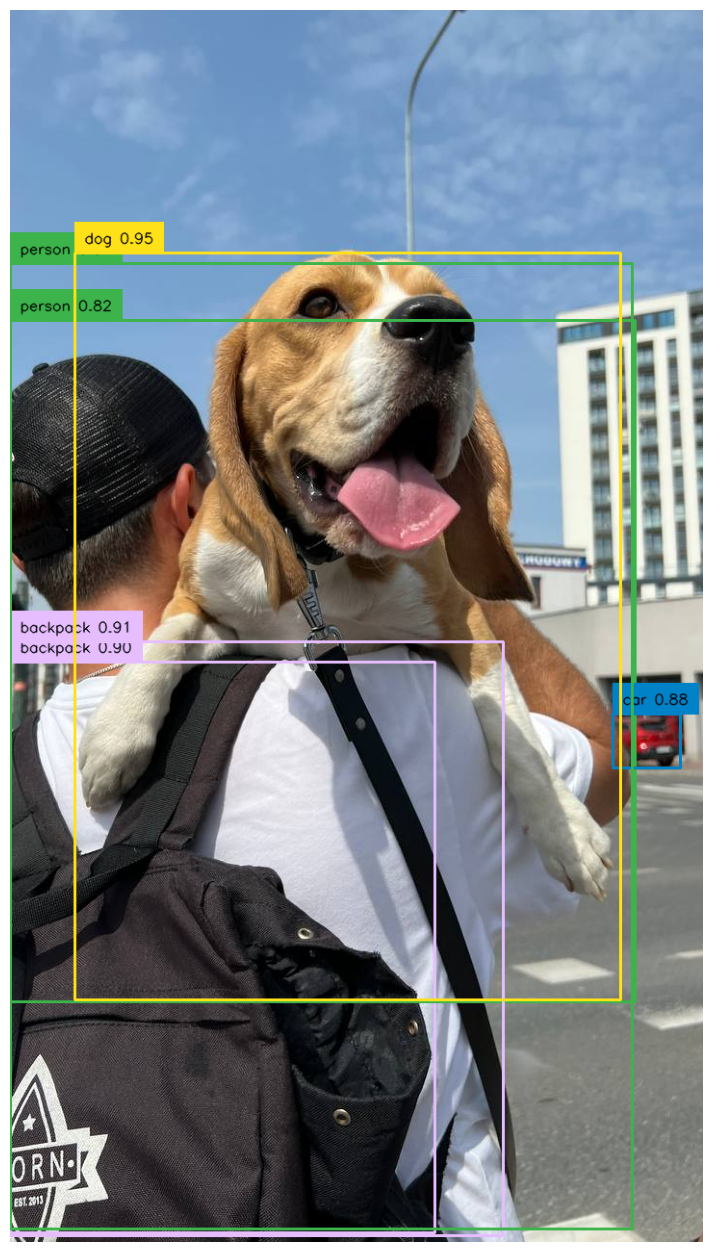

In [5]:
with torch.no_grad():

    # load image and predict
    image = cv2.imread("dog.jpeg")
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs, 
        threshold=CONFIDENCE_TRESHOLD, 
        target_sizes=target_sizes
    )[0]

# annotate
detections = sv.Detections.from_transformers(transformers_results=results)
print(detections)
labels = [
    f"{model.config.id2label[class_id]} {confidence:0.2f}" 
    for _, _, confidence, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline  
sv.plot_image(frame, (16, 16))

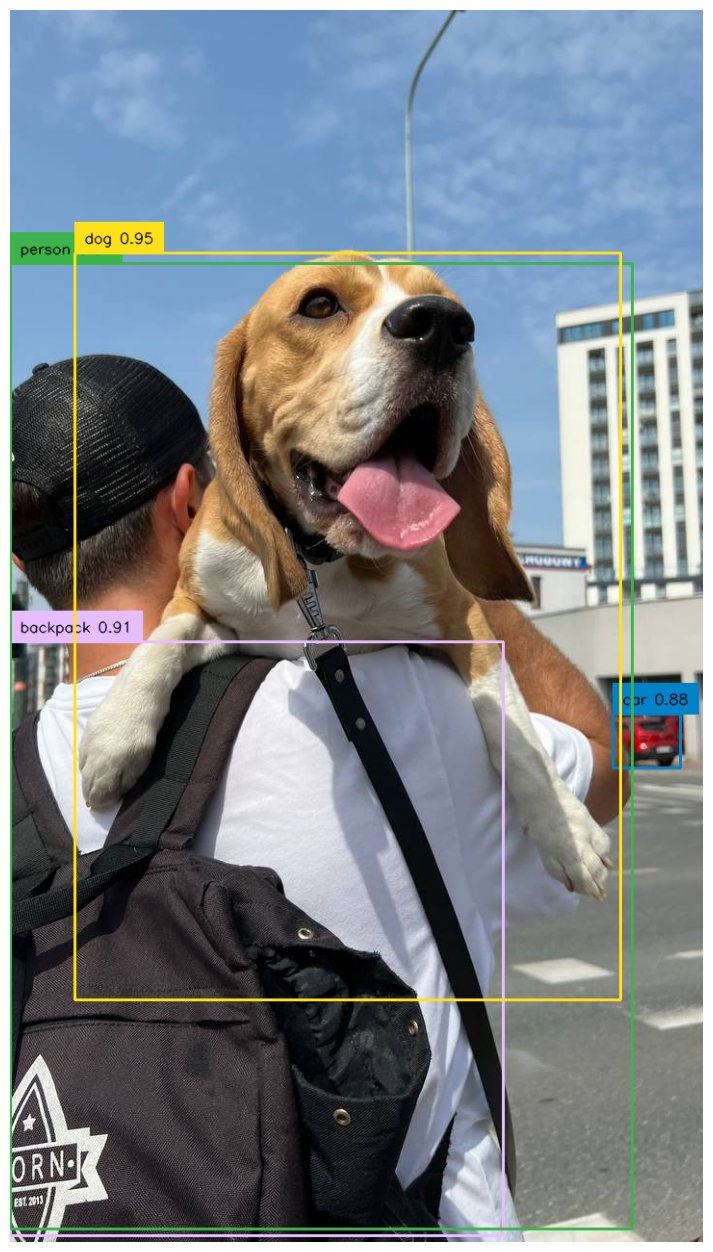

In [7]:
import cv2
import torch
import supervision as sv


with torch.no_grad():

    # load image and predict
    image = cv2.imread("dog.jpeg")
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs, 
        threshold=CONFIDENCE_TRESHOLD, 
        target_sizes=target_sizes
    )[0]

# annotate
# NMS (non maximum suppression) eliminates overlapping bounding boxes that refer to the same object
detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=IOU_TRESHOLD)

labels = [
    f"{model.config.id2label[class_id]} {confidence:0.2f}" 
    for _, _, confidence, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline  
sv.plot_image(frame, (16, 16))

In [ ]:
# Installed dataset by downloading zip from roboflow

In [8]:
import os
import torchvision


# settings
ANNOTATION_FILE_NAME = "_annotations.coco.json"
DATASET_LOC = "/home/sohum/Documents/Voxeleron/computer_vision/pytorch_demo/football-players-detection.v9i.coco/"
TRAIN_DIRECTORY = os.path.join(DATASET_LOC, "train")
VAL_DIRECTORY = os.path.join(DATASET_LOC, "valid")
TEST_DIRECTORY = os.path.join(DATASET_LOC, "test")


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self, 
        image_directory_path: str, 
        image_processor, 
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)        
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(
    image_directory_path=TRAIN_DIRECTORY, 
    image_processor=image_processor, 
    train=True)
VAL_DATASET = CocoDetection(
    image_directory_path=VAL_DIRECTORY, 
    image_processor=image_processor, 
    train=False)
TEST_DATASET = CocoDetection(
    image_directory_path=TEST_DIRECTORY, 
    image_processor=image_processor, 
    train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 250
Number of validation examples: 43
Number of test examples: 19


Image #33


/tmp/ipykernel_77584/3473150722.py:19: DeprecationWarning: from_coco_annotations is deprecated: Dataset loading and saving is going to be executed by supervision.dataset.core.Dataset
  detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)


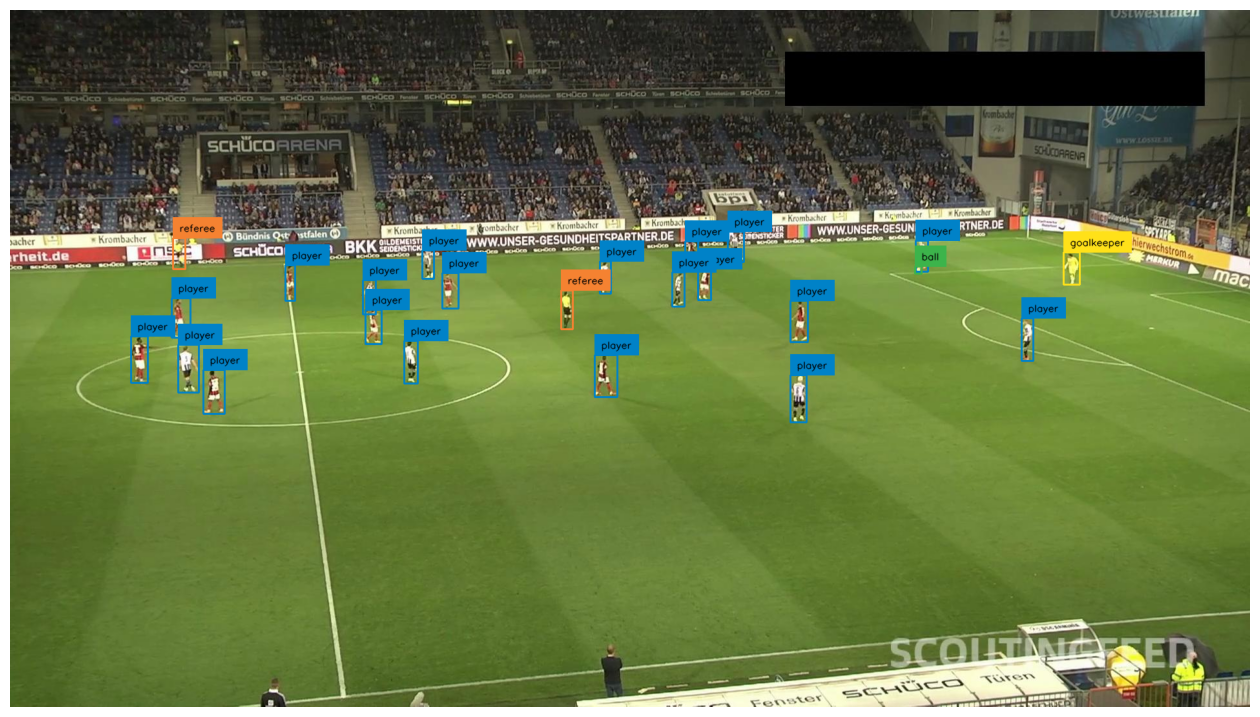

In [14]:
# visualize data
import random
import cv2
import numpy as np


# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons 
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}" 
    for _, _, _, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline  
sv.plot_image(image, (16, 16))